#Import dan Download Semua Package

In [1]:
import os
import pandas as pd

import nltk, os, re, string

from keras.layers import Input, LSTM, Bidirectional, SpatialDropout1D, Dropout, Flatten, Dense, Embedding, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

#Fetch Dataset dari Kaggle

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d gpreda/covid-world-vaccination-progress

df = pd.read_csv('country_vaccinations.csv')
df.head(10)


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /content. Or use the environment method.


,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.00,0.00,NaN,NaN,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
5,Afghanistan,AFG,2021-02-27,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
6,Afghanistan,AFG,2021-02-28,8200.0,8200.0,NaN,NaN,1367.0,0.02,0.02,NaN,35.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
7,Afghanistan,AFG,2021-03-01,NaN,NaN,NaN,NaN,1580.0,NaN,NaN,NaN,41.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
8,Afghanistan,AFG,2021-03-02,NaN,NaN,NaN,NaN,1794.0,NaN,NaN,NaN,46.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
9,Afghanistan,AFG,2021-03-03,NaN,NaN,NaN,NaN,2008.0,NaN,NaN,NaN,52.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/


#Daftar Nama Kolom

In [3]:
df.columns

Index(['country', 'iso_code', 'date', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated',
       'daily_vaccinations_raw', 'daily_vaccinations',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'daily_vaccinations_per_million',
       'vaccines', 'source_name', 'source_website'],
      dtype='object')

In [4]:
df.shape

(16203, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16203 entries, 0 to 16202
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              16203 non-null  object 
 1   iso_code                             16203 non-null  object 
 2   date                                 16203 non-null  object 
 3   total_vaccinations                   8668 non-null   float64
 4   people_vaccinated                    8352 non-null   float64
 5   people_fully_vaccinated              7129 non-null   float64
 6   daily_vaccinations_raw               6947 non-null   float64
 7   daily_vaccinations                   16086 non-null  float64
 8   total_vaccinations_per_hundred       8668 non-null   float64
 9   people_vaccinated_per_hundred        8352 non-null   float64
 10  people_fully_vaccinated_per_hundred  7129 non-null   float64
 11  daily_vaccinations_per_milli

#Daftar Negara

In [6]:
df.country.value_counts()


England                            250
Canada                             245
China                              244
Denmark                            241
Bahrain                            236
                                  ... 
Chad                                64
Cook Islands                        57
Haiti                               27
Ireland                              9
Bonaire Sint Eustatius and Saba      1
Name: country, Length: 95, dtype: int64

#Daftar Vaksin

In [7]:
df.vaccines.value_counts()

Johnson&Johnson, Moderna, Oxford/AstraZeneca, Pfizer/BioNTech                                  2298
Oxford/AstraZeneca                                                                             2212
Moderna, Oxford/AstraZeneca, Pfizer/BioNTech                                                   1291
Oxford/AstraZeneca, Pfizer/BioNTech                                                            1178
Oxford/AstraZeneca, Sinopharm/Beijing                                                           694
Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V                               595
Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac, Sputnik V                                         398
Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac                                                    384
Sinopharm/Beijing                                                                               358
Pfizer/BioNTech                                                                                 353


In [8]:
df_new = df.drop(columns=[
                          'iso_code', 'total_vaccinations', 'people_vaccinated', 
                          'people_fully_vaccinated', 'daily_vaccinations_raw', 
                          'daily_vaccinations', 'total_vaccinations_per_hundred', 
                          'people_vaccinated_per_hundred', 
                          'people_fully_vaccinated_per_hundred', 
                          'daily_vaccinations_per_million'
                          ])
df_new

,country,date,vaccines,source_name,source_website
0,Afghanistan,2021-02-22,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
1,Afghanistan,2021-02-23,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
2,Afghanistan,2021-02-24,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
3,Afghanistan,2021-02-25,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
4,Afghanistan,2021-02-26,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
...,...,...,...,...,...
16198,Ireland,2021-01-04,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Heath Service Executive,https://covid19ireland-geohive.hub.arcgis.com/
16199,Ireland,2021-01-05,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Heath Service Executive,https://covid19ireland-geohive.hub.arcgis.com/
16200,Ireland,2021-01-06,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Heath Service Executive,https://covid19ireland-geohive.hub.arcgis.com/
16201,Ireland,2021-01-07,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Heath Service Executive,https://covid19ireland-geohive.hub.arcgis.com/


#Download wordnet dan stopwords

In [9]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Lower-case all characters

In [10]:
df_new.country = df_new.country.apply(lambda x: x.lower())
df_new.date = df_new.date.apply(lambda x: x.lower())
df_new.vaccines = df_new.vaccines.apply(lambda x: x.lower())
df_new.source_name = df_new.source_name.apply(lambda x: x.lower())
df_new.source_website = df_new.source_website.apply(lambda x: x.lower())

#Menghapus functuation

In [11]:
def cleaner(data):
    return(data.translate(str.maketrans('','', string.punctuation)))
    df_new.country = df_new.country.apply(lambda x: cleaner(x))
    df_new.date = df_new.date.apply(lambda x: lem(x))
    df_new.vaccines = df_new.vaccines.apply(lambda x: lem(x))
    df_new.source_name = df_new.source_name.apply(lambda x: lem(x))
    df_new.source_website = df_new.source_website.apply(lambda x: lem(x))

#Lematization

In [12]:
lemmatizer = WordNetLemmatizer()
def lem(data):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(data.split())]))
    df_new.country = df_new.country.apply(lambda x: lem(x))
    df_new.date = df_new.date.apply(lambda x: lem(x))
    df_new.vaccines = df_new.vaccines.apply(lambda x: lem(x))
    df_new.source_name = df_new.source_name.apply(lambda x: lem(x))
    df_new.source_website = df_new.source_website.apply(lambda x: lem(x))

#Menghapus Angka

In [13]:
def rem_numbers(data):
    return re.sub('[0-9]+','',data)
    df_new['country'].apply(rem_numbers)
    df_new['date'].apply(rem_numbers)
    df_new['vaccines'].apply(rem_numbers)
    df_new['source_name'].apply(rem_numbers)
    df_new['source_website'].apply(rem_numbers)

#Menghapus Stopword

In [14]:
st_words = stopwords.words()
def stopword(data):
    return(' '.join([w for w in data.split() if w not in st_words ]))
    df_new.country = df_new.country.apply(lambda x: stopword(x))
    df_new.date = df_new.date.apply(lambda x: lem(x))
    df_new.vaccines = df_new.vaccines.apply(lambda x: lem(x))
    df_new.source_name = df_new.source_name.apply(lambda x: lem(x))
    df_new.source_website = df_new.source_website.apply(lambda x: lem(x))

#Menampilkan Data Setelah Cleansing

In [15]:
df_new.head(10)

,country,date,vaccines,source_name,source_website
0,afghanistan,2021-02-22,"johnson&johnson, oxford/astrazeneca, pfizer/bi...",world health organization,https://covid19.who.int/
1,afghanistan,2021-02-23,"johnson&johnson, oxford/astrazeneca, pfizer/bi...",world health organization,https://covid19.who.int/
2,afghanistan,2021-02-24,"johnson&johnson, oxford/astrazeneca, pfizer/bi...",world health organization,https://covid19.who.int/
3,afghanistan,2021-02-25,"johnson&johnson, oxford/astrazeneca, pfizer/bi...",world health organization,https://covid19.who.int/
4,afghanistan,2021-02-26,"johnson&johnson, oxford/astrazeneca, pfizer/bi...",world health organization,https://covid19.who.int/
5,afghanistan,2021-02-27,"johnson&johnson, oxford/astrazeneca, pfizer/bi...",world health organization,https://covid19.who.int/
6,afghanistan,2021-02-28,"johnson&johnson, oxford/astrazeneca, pfizer/bi...",world health organization,https://covid19.who.int/
7,afghanistan,2021-03-01,"johnson&johnson, oxford/astrazeneca, pfizer/bi...",world health organization,https://covid19.who.int/
8,afghanistan,2021-03-02,"johnson&johnson, oxford/astrazeneca, pfizer/bi...",world health organization,https://covid19.who.int/
9,afghanistan,2021-03-03,"johnson&johnson, oxford/astrazeneca, pfizer/bi...",world health organization,https://covid19.who.int/


In [16]:
category = pd.get_dummies(df_new.vaccines)
df_new_cat = pd.concat([df_new, category], axis=1)
df_new_cat = df_new_cat.drop(columns='vaccines')
df_new_cat.head(20)

,country,date,source_name,source_website,"abdala, soberana02","cansino, oxford/astrazeneca, pfizer/biontech, sinovac","cansino, sinopharm/beijing, sinopharm/wuhan, sinovac","covaxin, oxford/astrazeneca","covaxin, oxford/astrazeneca, sinopharm/beijing","covaxin, oxford/astrazeneca, sinopharm/beijing, sputnik v","covaxin, oxford/astrazeneca, sputnik v","johnson&johnson, moderna, oxford/astrazeneca, pfizer/biontech","johnson&johnson, moderna, oxford/astrazeneca, pfizer/biontech, sinopharm/beijing, sputnik v","johnson&johnson, moderna, oxford/astrazeneca, pfizer/biontech, sinovac","johnson&johnson, moderna, oxford/astrazeneca, pfizer/biontech, sputnik v","johnson&johnson, moderna, pfizer/biontech","johnson&johnson, oxford/astrazeneca","johnson&johnson, oxford/astrazeneca, pfizer/biontech, sinopharm/beijing","johnson&johnson, oxford/astrazeneca, pfizer/biontech, sinovac","johnson&johnson, oxford/astrazeneca, sinopharm/beijing","johnson&johnson, oxford/astrazeneca, sinopharm/beijing, sinovac","johnson&johnson, oxford/astrazeneca, sinopharm/beijing, sinovac, sputnik v","johnson&johnson, pfizer/biontech",moderna,"moderna, oxford/astrazeneca","moderna, oxford/astrazeneca, pfizer/biontech","moderna, oxford/astrazeneca, pfizer/biontech, sinopharm/beijing","moderna, oxford/astrazeneca, sinopharm/beijing, sinovac","moderna, oxford/astrazeneca, sinopharm/beijing, sputnik v","moderna, pfizer/biontech",oxford/astrazeneca,"oxford/astrazeneca, pfizer/biontech","oxford/astrazeneca, pfizer/biontech, sinopharm/beijing, sinovac","oxford/astrazeneca, pfizer/biontech, sinopharm/beijing, sinovac, sputnik v","oxford/astrazeneca, pfizer/biontech, sinopharm/beijing, sputnik v","oxford/astrazeneca, pfizer/biontech, sinovac","oxford/astrazeneca, pfizer/biontech, sinovac, sputnik v","oxford/astrazeneca, sinopharm/beijing","oxford/astrazeneca, sinopharm/beijing, sinovac, sputnik v","oxford/astrazeneca, sinovac","oxford/astrazeneca, sinovac, sputnik v","oxford/astrazeneca, sputnik v",pfizer/biontech,"pfizer/biontech, sinovac",sinopharm/beijing,"sinopharm/beijing, sputnik v",sputnik v
0,afghanistan,2021-02-22,world health organization,https://covid19.who.int/,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,afghanistan,2021-02-23,world health organization,https://covid19.who.int/,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,afghanistan,2021-02-24,world health organization,https://covid19.who.int/,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,afghanistan,2021-02-25,world health organization,https://covid19.who.int/,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,afghanistan,2021-02-26,world health organization,https://covid19.who.int/,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,afghanistan,2021-02-27,world health organization,https://covid19.who.int/,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,afghanistan,2021-02-28,world health organization,https://covid19.who.int/,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,afghanistan,2021-03-01,world health organization,https://covid19.who.int/,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,afghanistan,2021-03-02,world health organization,https://covid19.who.int/,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,afghanistan,2021-03-03,world health organization,https://covid19.who.int/,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#Inisiasi Variabel untuk membuat Model Fit

In [17]:
covid = df_new_cat['country'].values + '' + df_new_cat['date'].values + '' + df_new_cat['source_name'].values  + '' + df_new_cat['source_website'].values
vaksin = df_new_cat[['abdala, soberana02', 'cansino, oxford/astrazeneca, pfizer/biontech, sinovac', 'cansino, sinopharm/beijing, sinopharm/wuhan, sinovac', 'covaxin, oxford/astrazeneca', 'covaxin, oxford/astrazeneca, sinopharm/beijing', 'covaxin, oxford/astrazeneca, sinopharm/beijing, sputnik v', 'covaxin, oxford/astrazeneca, sputnik v', 'johnson&johnson, moderna, oxford/astrazeneca, pfizer/biontech', 'johnson&johnson, moderna, oxford/astrazeneca, pfizer/biontech, sinopharm/beijing, sputnik v', 'johnson&johnson, moderna, oxford/astrazeneca, pfizer/biontech, sinovac', 'johnson&johnson, moderna, oxford/astrazeneca, pfizer/biontech, sputnik v', 'johnson&johnson, moderna, pfizer/biontech', 'johnson&johnson, oxford/astrazeneca', 'johnson&johnson, oxford/astrazeneca, pfizer/biontech, sinopharm/beijing', 'johnson&johnson, oxford/astrazeneca, pfizer/biontech, sinovac', 'johnson&johnson, oxford/astrazeneca, sinopharm/beijing', 'johnson&johnson, oxford/astrazeneca, sinopharm/beijing, sinovac', 'johnson&johnson, oxford/astrazeneca, sinopharm/beijing, sinovac, sputnik v', 'johnson&johnson, pfizer/biontech', 'moderna', 'moderna, oxford/astrazeneca', 'moderna, oxford/astrazeneca, pfizer/biontech', 'moderna, oxford/astrazeneca, pfizer/biontech, sinopharm/beijing', 'moderna, oxford/astrazeneca, sinopharm/beijing, sinovac', 'moderna, oxford/astrazeneca, sinopharm/beijing, sputnik v', 'moderna, pfizer/biontech', 'oxford/astrazeneca', 'oxford/astrazeneca, pfizer/biontech', 'oxford/astrazeneca, pfizer/biontech, sinopharm/beijing, sinovac', 'oxford/astrazeneca, pfizer/biontech, sinopharm/beijing, sinovac, sputnik v', 'oxford/astrazeneca, pfizer/biontech, sinopharm/beijing, sputnik v', 'oxford/astrazeneca, pfizer/biontech, sinovac', 'oxford/astrazeneca, pfizer/biontech, sinovac, sputnik v', 'oxford/astrazeneca, sinopharm/beijing', 'oxford/astrazeneca, sinopharm/beijing, sinovac, sputnik v', 'oxford/astrazeneca, sinovac', 'oxford/astrazeneca, sinovac, sputnik v', 'oxford/astrazeneca, sputnik v', 'pfizer/biontech', 'pfizer/biontech, sinovac', 'sinopharm/beijing', 'sinopharm/beijing, sputnik v', 'sputnik v']].values

#Menampilkan Himpunan Covid

In [18]:
covid

array(['afghanistan2021-02-22world health organizationhttps://covid19.who.int/',
       'afghanistan2021-02-23world health organizationhttps://covid19.who.int/',
       'afghanistan2021-02-24world health organizationhttps://covid19.who.int/',
       ...,
       'ireland2021-01-06heath service executivehttps://covid19ireland-geohive.hub.arcgis.com/',
       'ireland2021-01-07heath service executivehttps://covid19ireland-geohive.hub.arcgis.com/',
       'ireland2021-01-08heath service executivehttps://covid'],
      dtype=object)

#Menampilkan Himpunan Vaksin

In [19]:
vaksin

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

#Split

In [20]:
covid_train, covid_test, vaksin_train, vaksin_test = train_test_split(covid, vaksin, test_size=0.2, shuffle=True)

# Tokenizer

In [21]:
tokenizer = Tokenizer(num_words=5000, oov_token='x', filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~ ')
tokenizer.fit_on_texts(covid_train) 
tokenizer.fit_on_texts(covid_test)
 
sekuens_train = tokenizer.texts_to_sequences(covid_train)
sekuens_test = tokenizer.texts_to_sequences(covid_test)
 
padded_train = pad_sequences(sekuens_train) 
padded_test = pad_sequences(sekuens_test)

#Membangun Model menggunakan Model Sequential

In [22]:
# model
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(43, activation='softmax')
])
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy',)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 43)                5547      
Total params: 440,875
Trainable params: 440,875
Non-trainable params: 0
_________________________________________________________________


#Implementasi Callback Apabila memenuhi Standar Akurasi yang Sudah Ditentukan

In [23]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      self.model.stop_training = True
      print("\nAkurasi pada training set dan validation set di atas 90%")
callbacks = myCallback()

#Pelatihan Model

In [24]:
history = model.fit(padded_train, vaksin_train, epochs=50, 
                    validation_data=(padded_test, vaksin_test), verbose=2, callbacks=[callbacks], validation_steps=30)

Epoch 1/50
406/406 - 37s - loss: 1.3493 - accuracy: 0.6423 - val_loss: 0.0914 - val_accuracy: 0.9818
Epoch 2/50
406/406 - 34s - loss: 0.0554 - accuracy: 0.9897 - val_loss: 8.6371e-04 - val_accuracy: 1.0000

Akurasi pada training set dan validation set di atas 90%


#Grafik Akurasi

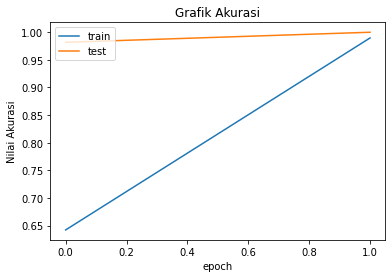

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Grafik Akurasi')
plt.ylabel('Nilai Akurasi')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Grafik Loss

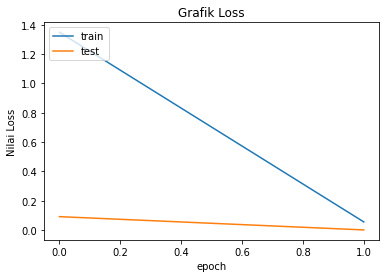

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Grafik Loss')
plt.ylabel('Nilai Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()